# Telephone rate recommendation

## Importing necessary libraries

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score 

from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LogisticRegression as logr

from sklearn.dummy import DummyClassifier
import seaborn as sns
from matplotlib import pyplot as plt

import os

## Getting data

In [2]:
path1 = '/datasets/users_behavior.csv'
path2 = r'C:\Users\exeve\Downloads\users_behavior.csv'

try:
    if os.path.exists(path1):
        data = pd.read_csv(path1)
    elif os.path.exists(path2):
        data = pd.read_csv(path2)
except:
    print('Something went wrong')

## Viewing data

<Axes: xlabel='messages', ylabel='Count'>

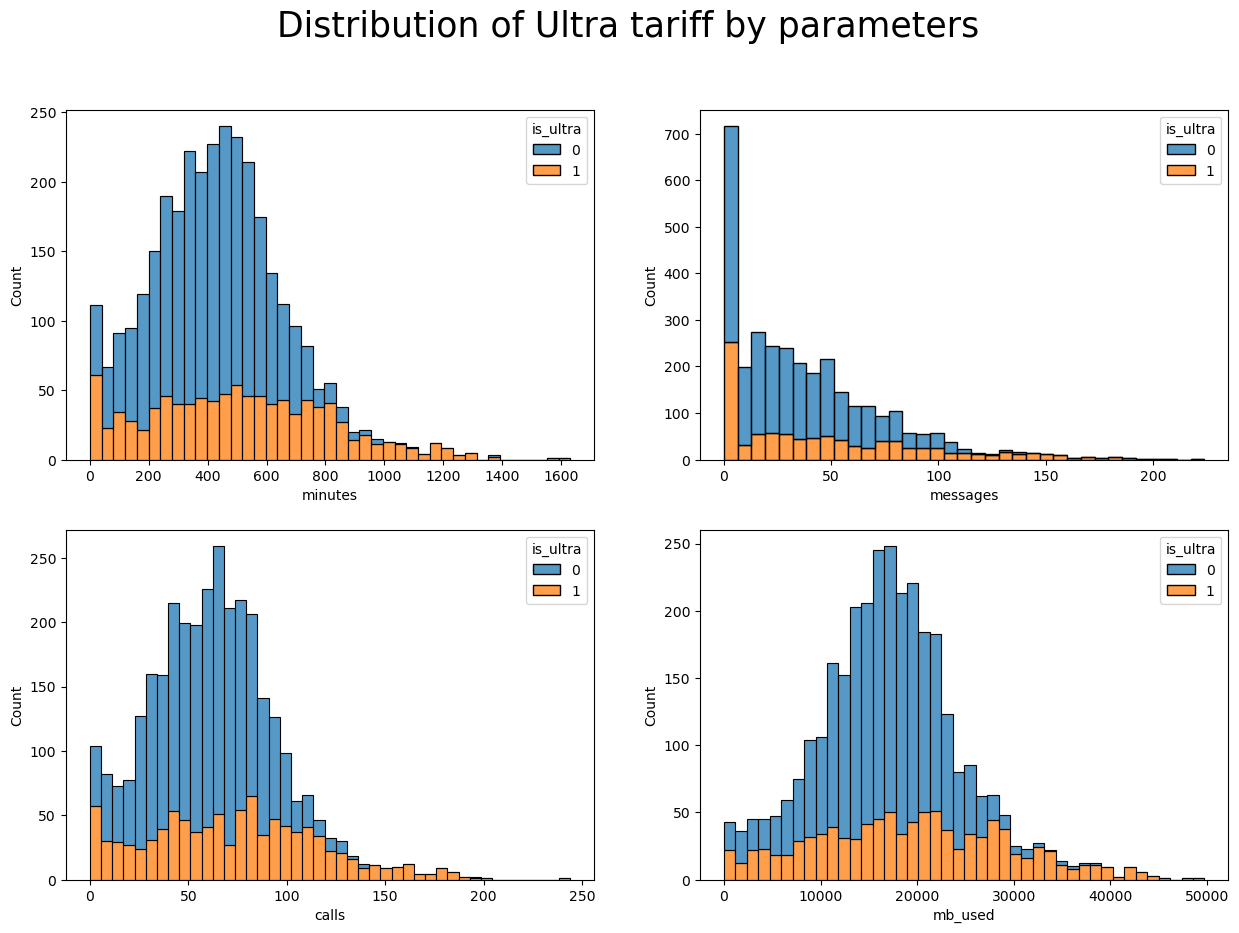

In [3]:
fig, ax = plt.subplots(2,2, figsize = (15,10))
fig.suptitle('Distribution of Ultra tariff by parameters', size=25)
sns.histplot(ax=ax[0,0],data = data, x = 'minutes', hue = 'is_ultra', multiple = 'stack')
sns.histplot(ax=ax[1,0], data = data, x = 'calls', hue = 'is_ultra', multiple = 'stack')
sns.histplot(ax=ax[1,1], data = data, x = 'mb_used', hue = 'is_ultra', multiple = 'stack')
sns.histplot(ax=ax[0,1], data = data, x = 'messages', hue = 'is_ultra', multiple = 'stack')

We can see that the most extreme values usually belong to Ultra rate users. This makes sense, since it is the rate that provides the most extensive service possibilities.

C:\Users\exeve\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Correlation graph')

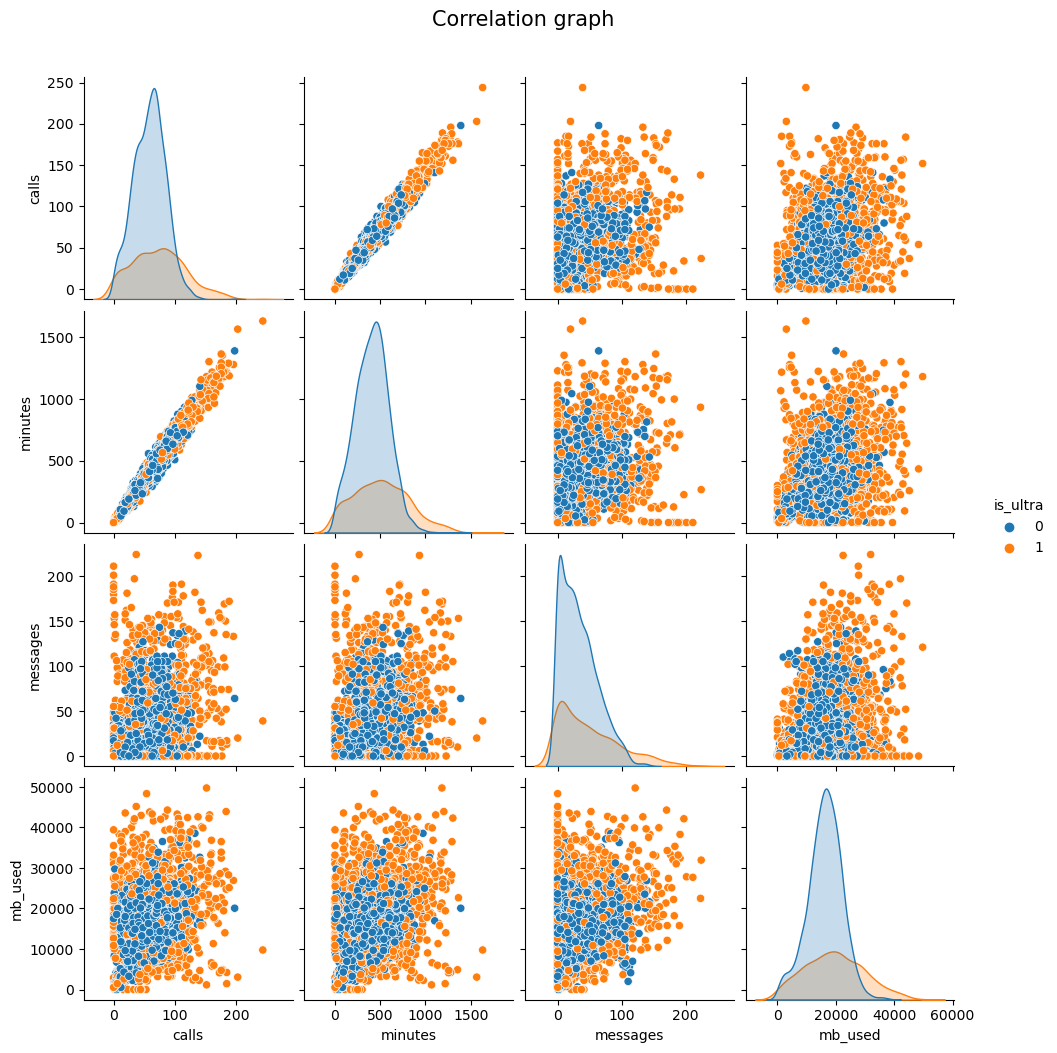

In [4]:
sns.pairplot(data=data, hue='is_ultra')
plt.suptitle('Correlation graph',size = 15, y = 1.05)

The only clear correlation that can be seen is between calls and minutes. In addition, users with the Ultra rate are those who make the most calls and talk for the most minutes.

## Removing correlated columns
We'll take the calls column off, since it's correlated with the minutes column. This will improve the accuracy of our model.

In [5]:
data = data.drop('calls', axis = 1)

## Getting train, test and validation samples

In [6]:
display(data) # let's have a look at the data set

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0
...,...,...,...,...
3209,910.98,20.0,35124.90,1
3210,190.36,0.0,3275.61,0
3211,634.44,70.0,13974.06,0
3212,462.32,90.0,31239.78,0


The is_ultra parameter is the target attribute. Features are all other columns the target is determined by.  

In [7]:
features = data.drop('is_ultra', axis = 1)
target = data['is_ultra']

- There is no hidden test sample. This means that the data needs to be divided into
three parts: training, validation and testing.
- The dimensions of test and validation sets will be equal.
- We will split the data in a ratio of 3:1:1 (60% training, 20% testing, 20% validation)

In [8]:
#splitting «data» into an 'f' sample (80%) and a testing sample (20%).
features_f, features_test, target_f, target_test = tts(features, target, test_size=0.2, random_state=12345)
#splitting the 'f' sample into a training (60% data) and a validation (20% data) samples
features_train, features_valid, target_train, target_valid = tts(features_f, target_f, test_size=0.25, random_state=12345)

In [9]:
# checking the samples

display(len(features_train), len(features_valid), len(features_test))

1928

643

643

Everything is correct.

## Exploring models

We will create a function that takes training data and validation data as parameters. This function will compare the accuracy of each model and select the hyperparameters with the best accuracy. It will also compare the models with each other and select the model with the best accuracy and print it on the screen.

In [10]:

best_model = None

def right_model(features_train, target_train, features_valid, target_valid):
    
    
    global best_model 
    best_result = 0
    best_depth_rfc = 0
    best_depth_dtc = 0
    best_est = 0
    
    for depth in range(1, 6):
        model = dtc(random_state=12345, max_depth=depth)
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid)
        if result > best_result:
            best_model = model
            best_result = result
            best_depth_dtc = depth
            
            
    for est in range(10, 101, 10):
        for depth in range (1, 11):
            model = rfc(random_state=12345, n_estimators=est, max_depth=depth) 
            model.fit(features_train, target_train) 
            result = model.score(features_valid, target_valid)
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth_rfc = depth
            
            
    model = logr(random_state=12345, solver='lbfgs', max_iter=1000)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        
        
    
        
    
    print('The best model is:', best_model,'; with an accuracy of', best_result)
    
right_model(features_train, target_train, features_valid, target_valid)



The best model is: RandomForestClassifier(max_depth=10, n_estimators=60, random_state=12345) ; with an accuracy of 0.7993779160186625


## Trying the model on the test sample

In [11]:
#training the model on the training set

best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print('Accuracy on the test sample:', accuracy)

Accuracy on the test sample: 0.7900466562986003


The accuracy on the test sample is still above 0.75, so the model is valid.

In [12]:
#training the model on validation + training samples

best_model.fit(features_f, target_f)
predictions_f = best_model.predict(features_test)
accuracy_f = accuracy_score(target_test, predictions_f)
print('Accuracy on the test sample:', accuracy)

Accuracy on the test sample: 0.7900466562986003


The accuracy is almost the same, just a little less.

## Checking the model for adequacy

- In order to determine the adequacy of the model, we will use the DummyClassifier model.
- In its "strategy" parameter, we will specify 'most_frequent', which causes the predict method to always return the most frequently occurring class label of the 'fit' method's second argument (target). 
- Any model with an accuracy higher than that of DummyClassifier can be considered an adequate model.

In [13]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_model.fit(features_train, target_train)
predictions = dummy_model.predict(features_test)
dummy_accuracy = accuracy_score(target_test, predictions)

best_tree_accuracy = 0
best_tree_model = None

best_log_accuracy = 0
best_log_model = None

best_forest_accuracy = 0
best_forest_model = None

    
    
for depth in range(1, 6):
    tree_model = dtc(random_state=12345, max_depth=depth)
    tree_model.fit(features_train, target_train) 
    tree_accuracy = tree_model.score(features_valid, target_valid)
    if tree_accuracy > best_tree_accuracy:
        best_tree_model = tree_model
        best_tree_accuracy = tree_accuracy
            
            
       
            
for est in range(10, 101, 10):
    for depth in range (1, 11):
        forest_model = rfc(random_state=12345, n_estimators=est, max_depth=depth) 
        forest_model.fit(features_train, target_train) 
        forest_accuracy = forest_model.score(features_valid, target_valid)
        if forest_accuracy > best_forest_accuracy:
                best_forest_model = forest_model
                best_forest_accuracy = forest_accuracy
                
                
            
log_model = logr(random_state=12345, solver='lbfgs', max_iter=1000)
log_model.fit(features_train, target_train)
log_accuracy = log_model.score(features_valid, target_valid)
if log_accuracy > best_log_accuracy:
    best_log_model = log_model
    best_log_accuracy = log_accuracy
        
        
        
if tree_accuracy <= dummy_accuracy:
    print('DecisionTreeClassifier is NOT an adequate model.')
else:
    print('DecisionTreeClassifier — is an adequate model.')
    
        
if forest_accuracy <= dummy_accuracy:
    print('RandomForestClassifier is NOT an adequate model.')
else:
    print('RandomForestClassifier — is an adequate model.')
    
if log_accuracy <= dummy_accuracy:
    print('LogisticClassifier is NOT an adequate model.')
else:
    print('LogisticClassifier — is an adequate model.')   

DecisionTreeClassifier — is an adequate model.
RandomForestClassifier — is an adequate model.
LogisticClassifier — is an adequate model.


All models are adequate, since the accuracy of all is higher than that of the dummy model.

## Conclusion

During the execution of this project the following was carried out:
- We have visually examined the distribution of both "Smart" and "Ultra" rates in terms of minutes, calls, messages and MB consumed.
- We checked the correlation between the parameters:
    - Calls and minutes correlated, so we removed the calls column in order to improve our model's results. 
- We explored the Tree Classifier, Random Forest Classifer and the Logistic Regression models, found the best hyperparameters for each and selected the best of them, which turned out to be RandomForestClassifier(max_depth=10, n_estimators=60, random_state=12345) with an accuracy of 0.8. 
- We checked the models for adequacy using the DummyClassifier model; all of them turned out to be adequate.
- **RandomForestClassifier(max_depth=10, n_estimators=60, random_state=12345)** is the endorsed model for recommending a rate to a client. 